# Cow + Univ3 DataPipeline

### Setup Jupyter Environment

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
# load parquet file into polars dataframe polars dataframe
cow_uni_chain_outer_pl = pl.read_parquet('cow_uni_chain_outer_pl.parquet')

In [3]:
# Replace null values with 0. In this case we are using the string "0"
# trades_swaps_converted_trunc_pl = cow_uni_chain_outer_pl.fill_null("0")

In [4]:
# return the larger value between trades_buy_sell_ratio and trades_sell_buy_ratio in a lambda function. This serves as a column equalization function for trades_buy_sell_ratio and trades_sell_buy_ratio
execution_prices_pl = cow_uni_chain_outer_pl.with_columns([
    (pl.col("trades_buy_sell_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sell_buy_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_amountOut_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_amountIn_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountOut_amountIn_ratio'),
])

In [5]:
# add columns that tell us the trade directionality for the trades and swaps. 
# we label the trade direction WETH -> USDC when WETH is in the CoW buy column and the UniV3 amountOut column. 
# Conversely, the USDC -> WETH direction is when USDC is in the CoW sell column and the Univ3 amountIn column.
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buyToken_id").apply(lambda x: True if x == 'WETH' else False)).alias('trades_buy_WETH'),
    (pl.col("swaps_tokenOut_id").apply(lambda x: True if x == 'WETH' else False)).alias('swaps_buy_WETH'),
])

In [6]:
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buy_WETH") & pl.col("swaps_buy_WETH")).alias('buy_WETH'), # buy WETH
    (~pl.col("trades_buy_WETH") & ~pl.col("swaps_buy_WETH")).alias('sell_WETH'), # sell WETH
])


### Plotting

In [7]:
# convert execution_prices_pl to pandas dataframe for easier plotting.
execution_prices_pd = execution_prices_pl.to_pandas()

# set trades_timestamp as index and order by trades_timestamp
execution_prices_pd = execution_prices_pd.set_index('trades_timestamp').sort_index()

In [8]:
# reindex execution_prices_pd. We take the mean over multiple timestamps of the same value.
reindexed_df = execution_prices_pd.groupby(execution_prices_pd.index).mean(numeric_only=True)

In [9]:
# # The reindex value converts booleans into 0s and 1s. Thus we convert buy_WETH 0 values to False boolean
# reindexed_df['buy_WETH'] = reindexed_df['buy_WETH'].apply(lambda x: False if x == 0 else True)

# # do same for WETH sel
# reindexed_df['sell_WETH'] = reindexed_df['sell_WETH'].apply(lambda x: False if x == 0 else True)

In [10]:
reindexed_price_df = reindexed_df[[
    'trades_sell_buy_ratio',                # cow price
    'swaps_amountOut_amountIn_ratio',       # univ3 price
    'prices_price',                         # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_WETH'                              # trade direction.
    ]]

# rename columns
reindexed_price_df.columns = [
    'cow_price',                            # cow price
    'univ3_price',                          # univ3 price
    'chain_price',                          # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_WETH'                              # trade direction.
]

In [11]:
# forward fill reindexed_price_df
reindexed_price_df = reindexed_price_df.fillna(method='ffill')

In [12]:
# convert transaction_gas_fee into usd amount
reindexed_price_df['transaction_gas_fee_one_hop_usd'] = reindexed_price_df['transaction_gas_fee_one_hop'] * reindexed_price_df['univ3_price']
reindexed_price_df['transaction_gas_fee_median_usd'] = reindexed_price_df['transaction_gas_fee_median'] * reindexed_price_df['univ3_price']

In [13]:
# filter trade directions
buy_WETH_df = reindexed_price_df[reindexed_price_df['buy_WETH'] == True]
sell_WETH_df = reindexed_price_df[reindexed_price_df['buy_WETH'] == False]

In [14]:
# single hop gas adjusted prices
buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_WETH_df.loc[:, 'univ3_price'] + buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_WETH_df.loc[:, 'univ3_price'] - sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']

# add new price values that add the gas cost
buy_WETH_df.loc[:, 'univ3_gas_median_price'] = buy_WETH_df.loc[:, 'univ3_price'] + buy_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
sell_WETH_df.loc[:, 'univ3_gas_median_price'] = sell_WETH_df.loc[:, 'univ3_price'] - sell_WETH_df.loc[:, 'transaction_gas_fee_median_usd']

/tmp/ipykernel_20824/4170348146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_WETH_df.loc[:, 'univ3_price'] + buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
/tmp/ipykernel_20824/4170348146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_WETH_df.loc[:, 'univ3_price'] - sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
/tmp/ipykernel_20824/4170348146.py:6: SettingWithCopyWarnin

In [15]:
# do a heuristic filter to remove some incorectly calculated outlier data. If transaction_gas_fee_one_hop_usd is greater than 250, then remove it
buy_WETH_df = buy_WETH_df[buy_WETH_df['transaction_gas_fee_median_usd'] < 200]
sell_WETH_df = sell_WETH_df[sell_WETH_df['transaction_gas_fee_median_usd'] < 200]

In [16]:
# convert index to datetime format
sell_WETH_df.index = pd.to_datetime(sell_WETH_df.index, utc=True, unit='s')
buy_WETH_df.index = pd.to_datetime(buy_WETH_df.index, utc=True, unit='s')

In [17]:
# first non nan value in sell_WETH_df['cow_price']
first_valid_index_buy = sell_WETH_df['cow_price'].first_valid_index()
print(f'first valid index is: {first_valid_index_buy}')

first valid index is: 2023-02-13 03:22:23+00:00


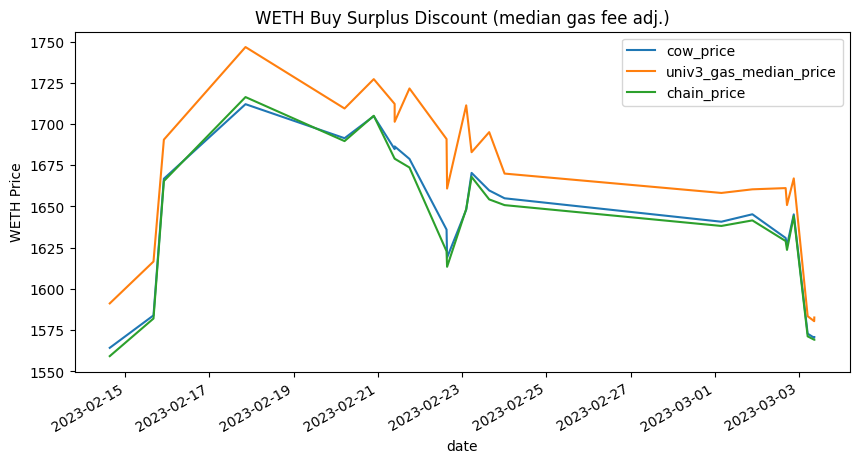

In [18]:
# plot cow price vs univ3 and chain gas adjusted prices
buy_WETH_df.loc[first_valid_index_buy:][['cow_price', 'univ3_gas_median_price', 'chain_price']].plot(figsize=(10,5))
plt.title("WETH Buy Surplus Discount (median gas fee adj.)")
plt.xlabel('date')
plt.ylabel('WETH Price')
plt.show();

In [19]:
# first non nan value in sell_WETH_df['cow_price']
first_valid_index_sell = sell_WETH_df['cow_price'].first_valid_index()
print(f'first valid index is: {first_valid_index_sell}')

first valid index is: 2023-02-13 03:22:23+00:00


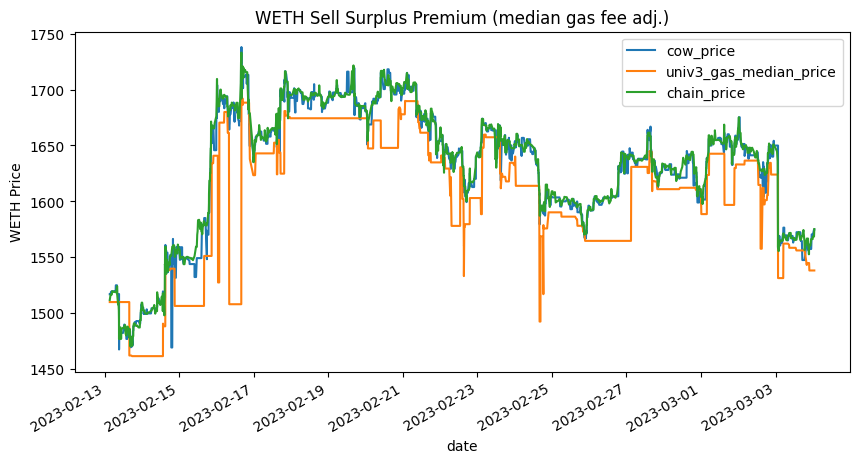

In [20]:
# plot cow price vs univ3 and chain gas adjusted prices after first valid index 1676258543
sell_WETH_df.loc[first_valid_index_sell:][['cow_price', 'univ3_gas_median_price', 'chain_price']].plot(figsize=(10,5))
plt.title("WETH Sell Surplus Premium (median gas fee adj.)")
plt.xlabel('date')
plt.ylabel('WETH Price')
plt.show();

### Price Differences

In [21]:
# get the price price difference percent between cow and univ3 gas adjusted price in buy_WETH_df
buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (buy_WETH_df['cow_price'] - buy_WETH_df['univ3_gas_single_hop_price']) / buy_WETH_df['cow_price'] * 100
buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (buy_WETH_df['cow_price'] - buy_WETH_df['univ3_gas_median_price']) / buy_WETH_df['cow_price'] * 100

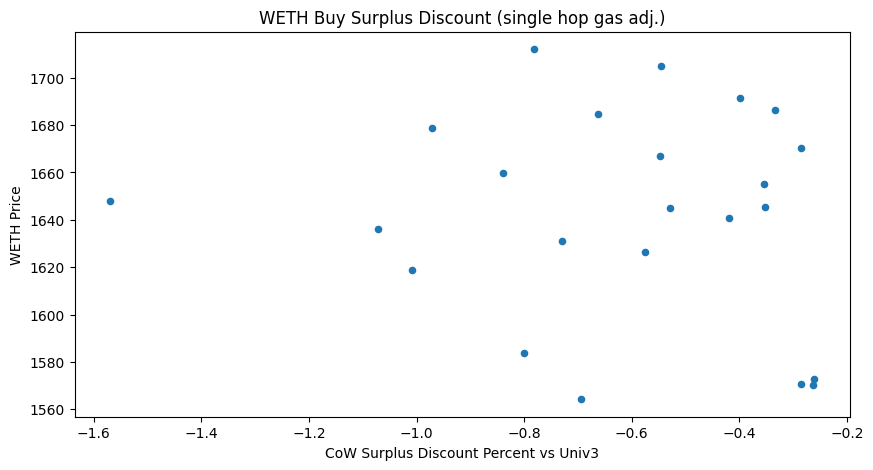

In [22]:
# plot scatterplot
buy_WETH_df.loc[first_valid_index_buy:].plot(figsize=(10,5), kind='scatter', x='cow_univ3_gas_adj_price_diff_percent_single', y='cow_price')

plt.xlabel("CoW Surplus Discount Percent vs Univ3")
plt.ylabel("WETH Price")
plt.title("WETH Buy Surplus Discount (single hop gas adj.)")
plt.show();

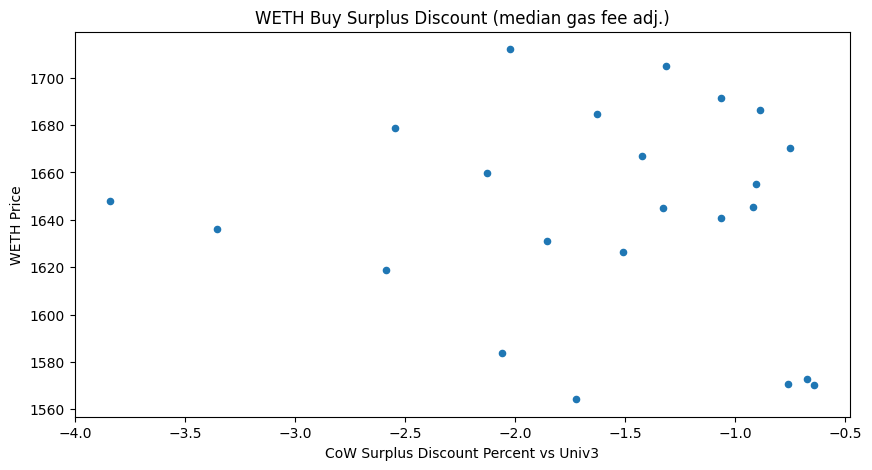

In [30]:
# plot scatterplot
buy_WETH_df.loc[first_valid_index_buy:].plot(figsize=(10,5), kind='scatter', x='cow_univ3_gas_adj_price_diff_percent_median', y='cow_price')

plt.xlabel("CoW Surplus Discount Percent vs Univ3")
plt.ylabel("WETH Price")
plt.title("WETH Buy Surplus Discount (median gas fee adj.)")
plt.show();

In [24]:
# get the price price difference percent between cow and univ3 gas adjusted price in sell_WETH_df
sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_WETH_df['cow_price'] - sell_WETH_df['univ3_gas_single_hop_price']) / sell_WETH_df['cow_price'] * 100
sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_WETH_df['cow_price'] - sell_WETH_df['univ3_gas_median_price']) / sell_WETH_df['cow_price'] * 100

/tmp/ipykernel_20824/3219638629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_WETH_df['cow_price'] - sell_WETH_df['univ3_gas_single_hop_price']) / sell_WETH_df['cow_price'] * 100
/tmp/ipykernel_20824/3219638629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_WETH_df['cow_price'] - sell_WETH_df['univ3_gas_median_price']) / sell_WETH_df['cow_price'] * 100


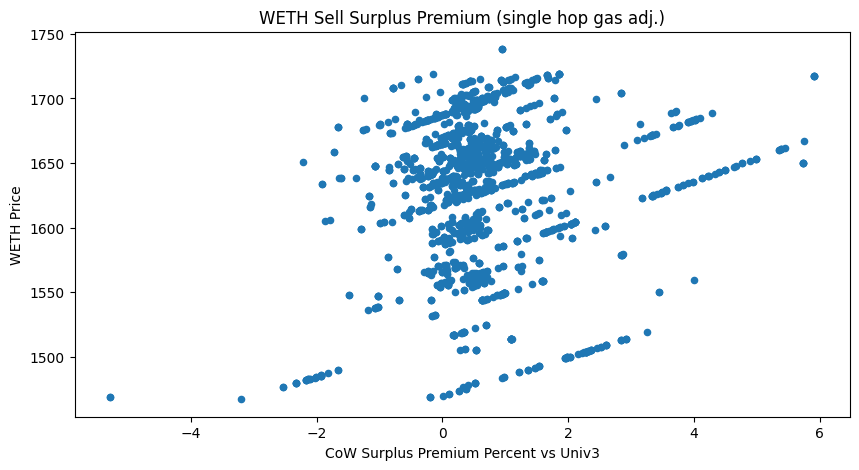

In [25]:
# plot scatterplot
sell_WETH_df.loc[first_valid_index_sell:].plot(figsize=(10,5), kind='scatter', x='cow_univ3_gas_adj_price_diff_percent_single', y='cow_price')


plt.xlabel("CoW Surplus Premium Percent vs Univ3")
plt.ylabel("WETH Price")
plt.title("WETH Sell Surplus Premium (single hop gas adj.)")
plt.show();

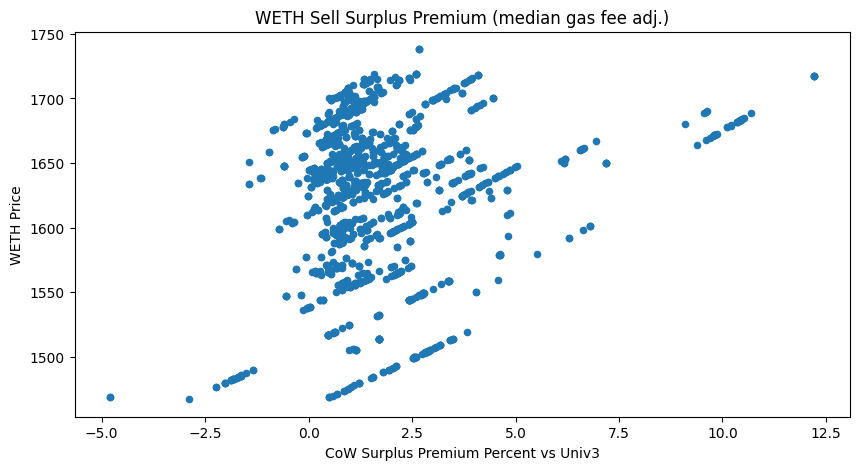

In [29]:
# plot scatterplot
sell_WETH_df.loc[first_valid_index_sell:].plot(figsize=(10,5), kind='scatter', x='cow_univ3_gas_adj_price_diff_percent_median', y='cow_price')

plt.xlabel("CoW Surplus Premium Percent vs Univ3")
plt.ylabel("WETH Price")
plt.title("WETH Sell Surplus Premium (median gas fee adj.)")
plt.show();

In [27]:
# statistics for buy_WETH_df single hop price difference
buy_WETH_df[['cow_univ3_gas_adj_price_diff_percent_single', 'cow_univ3_gas_adj_price_diff_percent_median']].describe()

,cow_univ3_gas_adj_price_diff_percent_single,cow_univ3_gas_adj_price_diff_percent_median
count,24.000000,24.000000
mean,-0.608043,-1.574746
std,0.323849,0.854365
min,-1.570014,-3.842585
25%,-0.785529,-2.032846
50%,-0.546358,-1.374540
75%,-0.347266,-0.900291
max,-0.260381,-0.640252


In [28]:
sell_WETH_df[['cow_univ3_gas_adj_price_diff_percent_single', 'cow_univ3_gas_adj_price_diff_percent_median']].describe()

,cow_univ3_gas_adj_price_diff_percent_single,cow_univ3_gas_adj_price_diff_percent_median
count,1723.000000,1723.000000
mean,0.673744,1.657821
std,1.194688,1.847549
min,-5.287687,-4.806039
25%,0.112381,0.722431
50%,0.473735,1.179211
75%,1.000604,2.194400
max,5.915937,12.219828
